In [5]:
import numpy as np
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport

In [6]:
from collections import Counter
import requests

with requests.get(
    "https://docs.google.com/spreadsheets/d/1wduqo5WyYmCpaGnE81sLNGU0VSodIekMfpmEwU0fGqs/export?format=csv") as r, open("features.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)

with requests.get(
    "https://docs.google.com/spreadsheets/d/1gvZ03uAL6THwd04Y98GtIj6SeAHiKyQY5UisuuyFSUs/export?format=csv") as r, open("target.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)

**Introducción**

En este trabajo se analizarán varios datos recolectados, de una serie de atributos climáticos por día en distintos barrios y del comportamiento de una máquina que hace llover hamburguesas, con el objetivo de determinar si la misma se activará al día siguiente o no.

Tenemos como objetivo interpretear los datos, visualizandolos, y encontrar relaciones entre los mismos, logrando asi determinar patrones entre ellos, con la finalidad de utilizar lo aprendido para realizar un baseline.

Leemos los archivos de los datasets al data frame:

In [7]:
df_features = pd.read_csv("features.csv")

df_target = pd.read_csv("target.csv")

/home/facundo/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Unimos la tabla donde se encuentra nuestro valor target (la variable booleana que indica si llovieron o no hamburguesas al dia siguiente) con la tabla de features, todo en un mismo Data Frame, a través del id.

In [8]:
df = df_features.merge(df_target, left_on='id', right_on='id')

Imprimimos las primeras filas del dataframe, probando que la lectura haya sido correcta, viendo el tipo de datos.

In [9]:
df.head()

,barrio,dia,direccion_viento_tarde,direccion_viento_temprano,horas_de_sol,humedad_tarde,humedad_temprano,id,llovieron_hamburguesas_hoy,mm_evaporados_agua,...,presion_atmosferica_temprano,rafaga_viento_max_direccion,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano,llovieron_hamburguesas_al_dia_siguiente
0,Retiro,2016-10-11,Este,Nornoreste,10.7,59.0,56.0,86942,no,16.0,...,1010.2,Estesureste,33.0,29.2,16.8,24.1,25.3,19.0,4.0,no
1,Vélez Sársfield,2016-03-28,Sur,suroeste,0.0,49.0,83.0,102098,no,2.6,...,1021.4,Sur,31.0,16.9,10.6,16.4,12.3,13.0,7.0,no
2,Palermo,2017-05-11,Sursureste,Norte,4.3,59.0,83.0,67154,no,2.4,...,1026.5,Norte,26.0,16.6,4.4,15.7,9.4,9.0,13.0,no
3,Mataderos,2012-05-07,suroeste,Sur,NaN,67.0,93.0,50245,no,NaN,...,1020.0,Oestesuroeste,13.0,11.4,0.8,11.1,4.0,6.0,6.0,no
4,Recoleta,2014-06-19,Nornoreste,Nornoreste,0.8,94.0,97.0,82904,no,0.8,...,1021.9,Nornoreste,33.0,11.6,6.7,11.2,8.8,11.0,15.0,no


Detectamos si hay valores faltantes.

In [10]:
df.isnull()

,barrio,dia,direccion_viento_tarde,direccion_viento_temprano,horas_de_sol,humedad_tarde,humedad_temprano,id,llovieron_hamburguesas_hoy,mm_evaporados_agua,...,presion_atmosferica_temprano,rafaga_viento_max_direccion,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano,llovieron_hamburguesas_al_dia_siguiente
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116363,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
116364,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
116365,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
116366,False,False,False,True,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


Imprimimos los dtypes del dataframe leido. Esta funcion nos devuelve una Serie con el tipo de datos de cada columna. El índice del resultado son las columnas del DataFrame original. Las columnas con tipos mixtos se almacenan con el dtype 'object'.

In [11]:
df.dtypes

barrio                                      object
dia                                         object
direccion_viento_tarde                      object
direccion_viento_temprano                   object
horas_de_sol                               float64
humedad_tarde                              float64
humedad_temprano                           float64
id                                           int64
llovieron_hamburguesas_hoy                  object
mm_evaporados_agua                         float64
mm_lluvia_dia                              float64
nubosidad_tarde                            float64
nubosidad_temprano                         float64
presion_atmosferica_tarde                   object
presion_atmosferica_temprano               float64
rafaga_viento_max_direccion                 object
rafaga_viento_max_velocidad                float64
temp_max                                   float64
temp_min                                   float64
temperatura_tarde              

Podemos observar como la columna de 'presion_atmosferica_tarde' figura con el tipo de dato object, cuando deberia ser del tipo float64. Esto se debe a que contiene valores basura. Convertimos el tipo de la columna a un tipo numérico, y  establecimos los valores inválidos como NaN.

In [12]:
df['presion_atmosferica_tarde'] = pd.to_numeric(df['presion_atmosferica_tarde'],errors='coerce')

Eliminamos todas las filas del detaframe donde haya valores faltantes en la columna target.

In [13]:
df = df.dropna(subset=['llovieron_hamburguesas_al_dia_siguiente'])

Convertimos la columna con fechas de object al tipo de dato datetime.

In [14]:
df['dia'] = pd.to_datetime(df['dia'])

Verificamos aquellos valores que sean negativos haciendo una tabla. Observamos que solo se encuentran valores negativos en las columnas de las tempreaturas, lo cual corresponde.

In [109]:
columnas_con_numeros = ['horas_de_sol', 'humedad_tarde', 'humedad_temprano', 'id', 'mm_evaporados_agua', 'mm_lluvia_dia', 'nubosidad_tarde', 'nubosidad_temprano', 'presion_atmosferica_temprano', 'presion_atmosferica_tarde', 'rafaga_viento_max_velocidad', 'temp_max', 'temp_min', 'temperatura_tarde', 'temperatura_temprano', 'velocidad_viendo_tarde', 'velocidad_viendo_temprano']

(df[columnas_con_numeros] < 0).any().to_frame('Valores negativos?')

,Valores negativos?
horas_de_sol,False
humedad_tarde,False
humedad_temprano,False
id,False
mm_evaporados_agua,False
mm_lluvia_dia,False
nubosidad_tarde,False
nubosidad_temprano,False
presion_atmosferica_temprano,False
presion_atmosferica_tarde,False


# Inicialmente nos planteamos las siguientes preguntas:

¿Como se relaciona lluvia con la lluvia de hamburguesas?

¿Cómo varia el clima según la fecha?

¿Como varía el clima segun el barrio?

¿Como se relaciona la temperatura con la variable target?

¿Como se relaciona la humedad con la variable target?

¿Como se relaciona la nubosidad con la variable target?

¿Como se relaciona el viento con la variable target?

¿Como se relaciona la presión atmosférica con la variable target?

¿Como se relaciona los milimetros evaporados de agua con la variable target?

¿Como se relaciona las horas de sol con la variable target?


## ¿Como se relaciona lluvia con la lluvia de hamburguesas?
Analizamos la variable target, realizando un grafico de torta. Vemos que la mayoria de las veces no llovieron hamburguesas al dia siguiente.

<AxesSubplot:ylabel='llovieron_hamburguesas_al_dia_siguiente'>

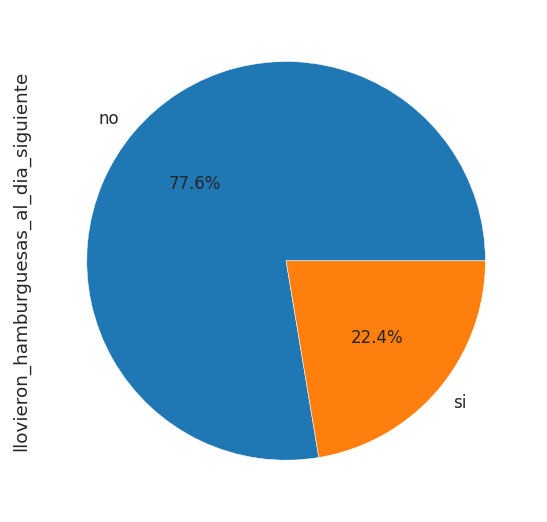

In [98]:
df['llovieron_hamburguesas_al_dia_siguiente'].value_counts().plot(kind='pie', autopct='%1.1f%%')


Analizamos cuando llueve dos dias consecutivos, graficando los porcentaje de dias que llueven, o no, hamburguesas al dia siguiente, habiendo llovido hamburguesas ese dia. 

Observamos que cuando llueve, al dia siguiente llueve tambien en el 46% de los casos.

<AxesSubplot:ylabel='llovieron_hamburguesas_al_dia_siguiente'>

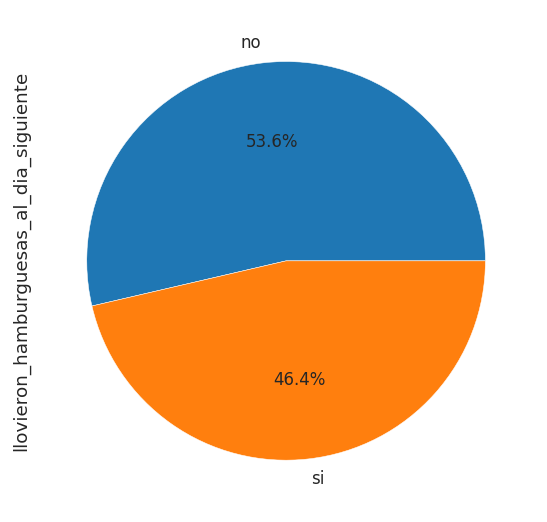

In [102]:
df[df['llovieron_hamburguesas_hoy']=='si']['llovieron_hamburguesas_al_dia_siguiente'].value_counts().plot(kind='pie', autopct='%1.1f%%')


Analizamos la coincidencia entre los valores de la columna 'llovieron_hamburguesas_hoy' y 'llovieron_hamburguesas_al_dia_siguiente', y observamos que es del 75%.

In [99]:
(df['llovieron_hamburguesas_hoy'] == df['llovieron_hamburguesas_al_dia_siguiente']).mean()

0.7551547978088262

<AxesSubplot:ylabel='Density'>

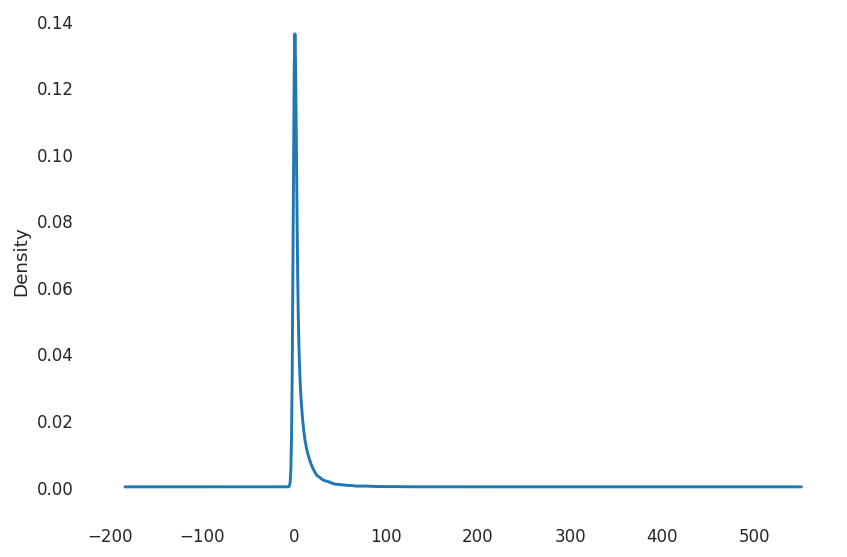

In [103]:
df[df['mm_lluvia_dia']>0]['mm_lluvia_dia'].plot(kind='density')

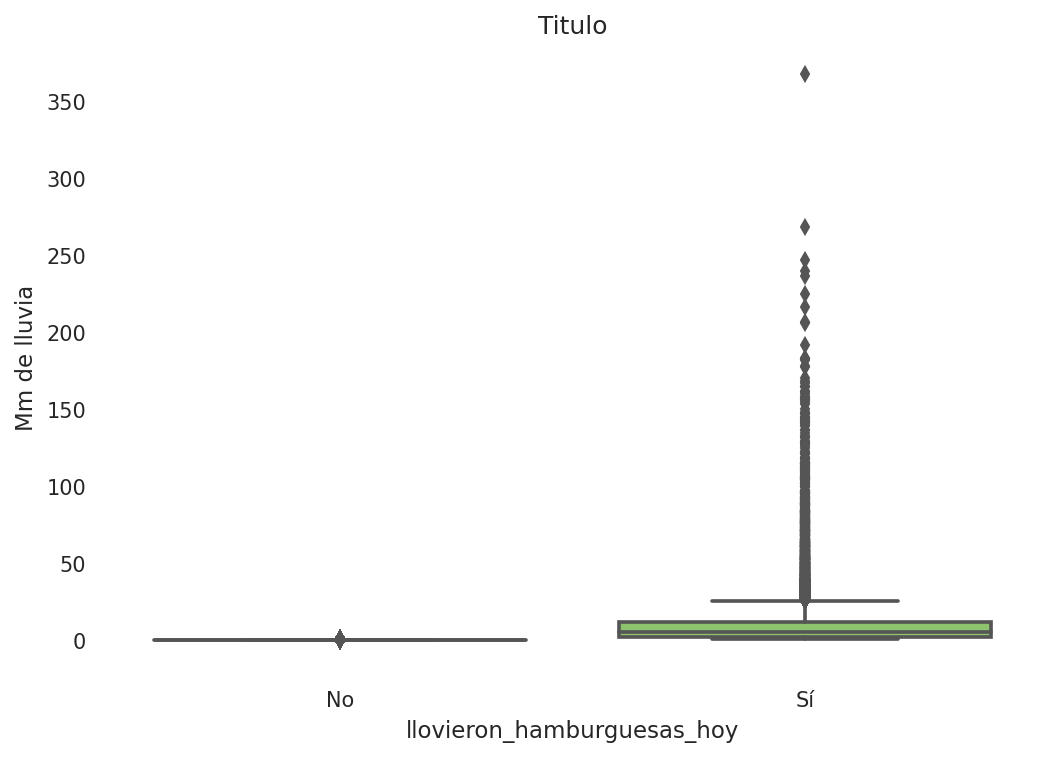

In [104]:
import seaborn as sns

plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
       
    y='mm_lluvia_dia',
    x='llovieron_hamburguesas_hoy',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Mm de lluvia")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

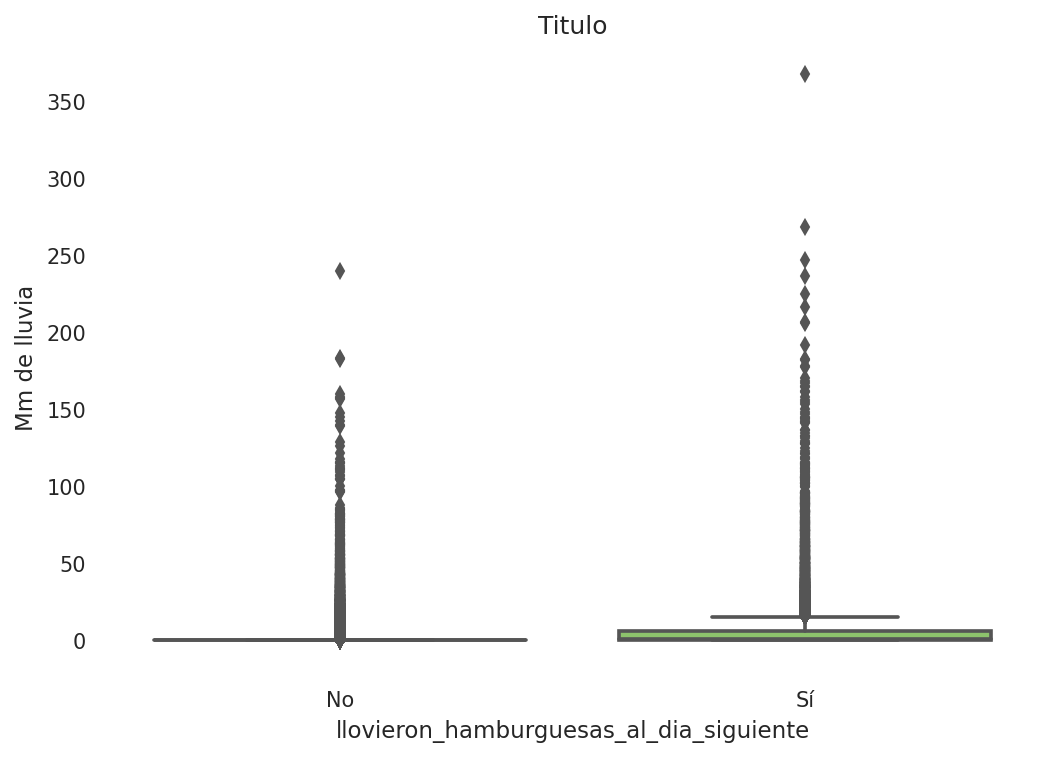

In [107]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
    y='mm_lluvia_dia',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Mm de lluvia")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

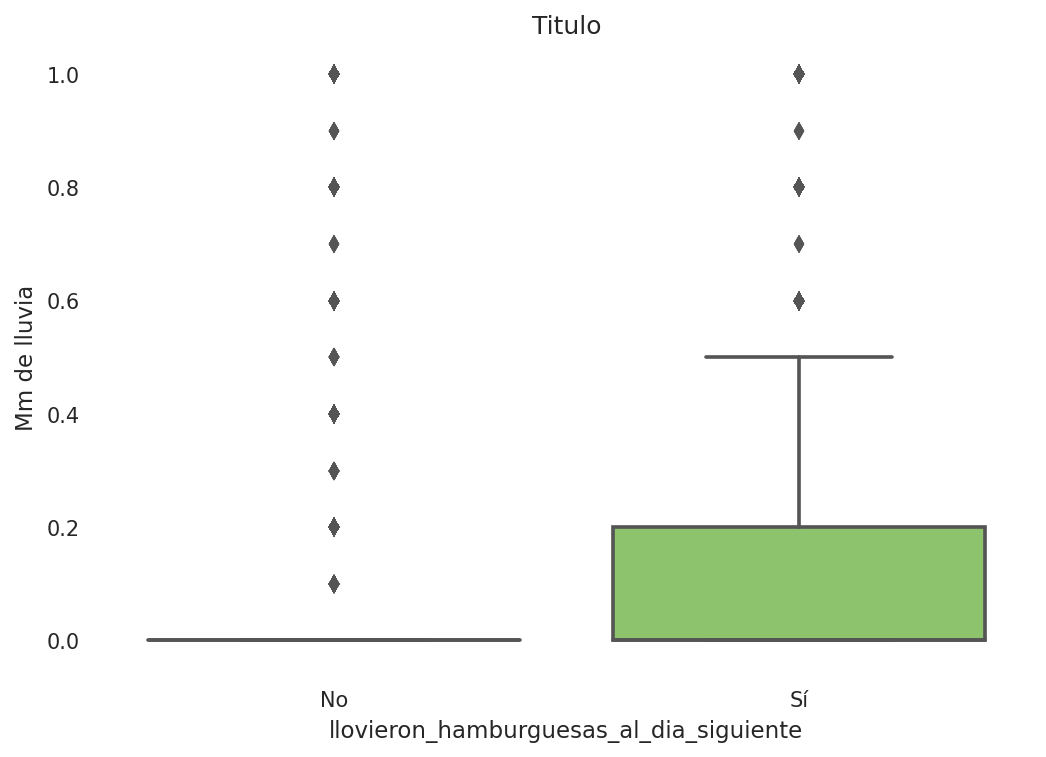

In [153]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df_no,
    y='mm_lluvia_dia',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Mm de lluvia")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

## ¿Cómo varia el clima según la fecha?


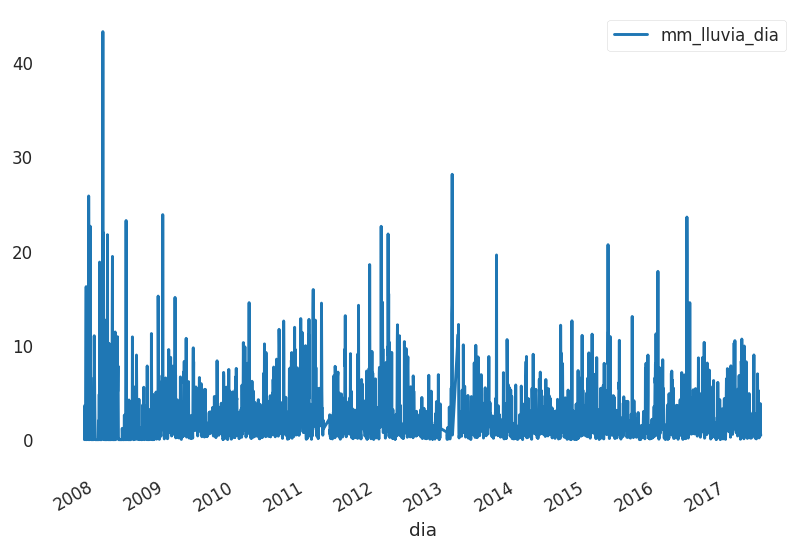

In [110]:
plt.rcParams["figure.dpi"] = 120

df[['dia', 'mm_lluvia_dia']].groupby('dia').mean().plot(kind='line')
plt.show()

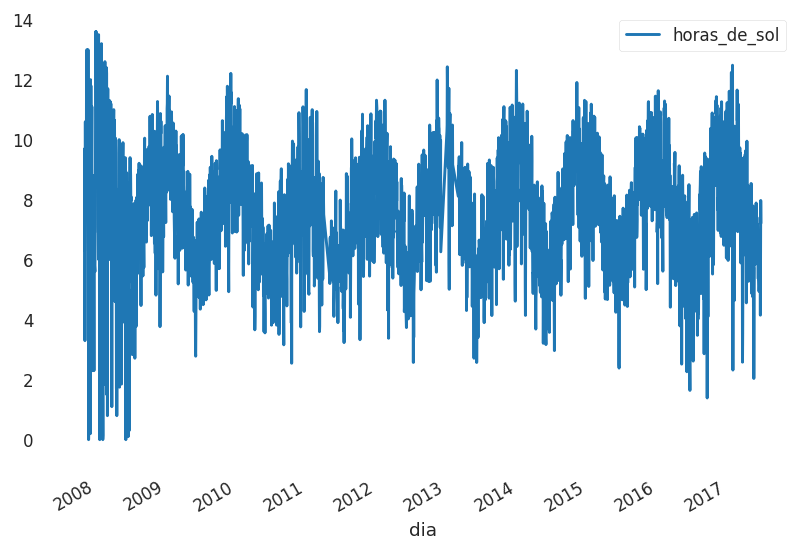

In [111]:
plt.rcParams["figure.dpi"] = 120

df[['dia', 'horas_de_sol']].groupby('dia').mean().plot(kind='line')
plt.show()

<AxesSubplot:xlabel='mes'>

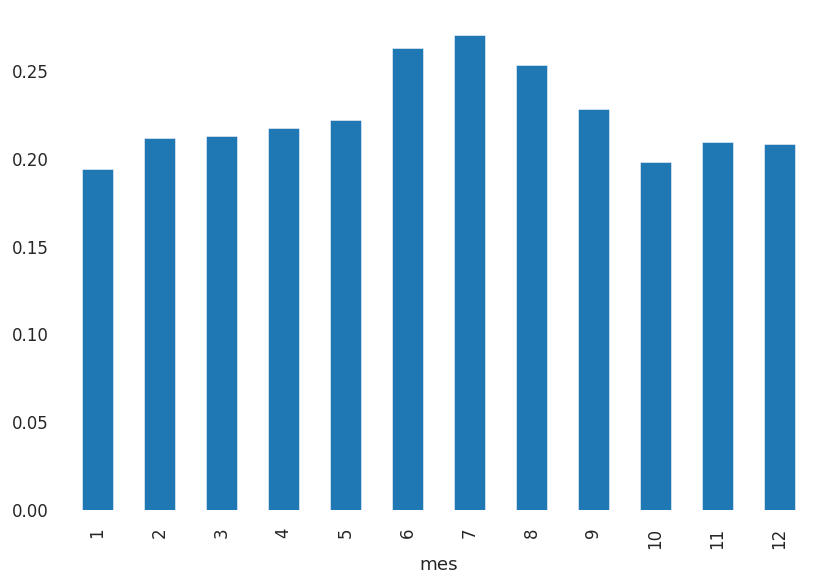

In [112]:
((df[df['llovieron_hamburguesas_al_dia_siguiente'] == 'si'].groupby(df['dia'].dt.month).size())/(df.groupby(df['dia'].dt.month).size())).plot(kind='bar', xlabel='mes')


<AxesSubplot:xlabel='mes'>

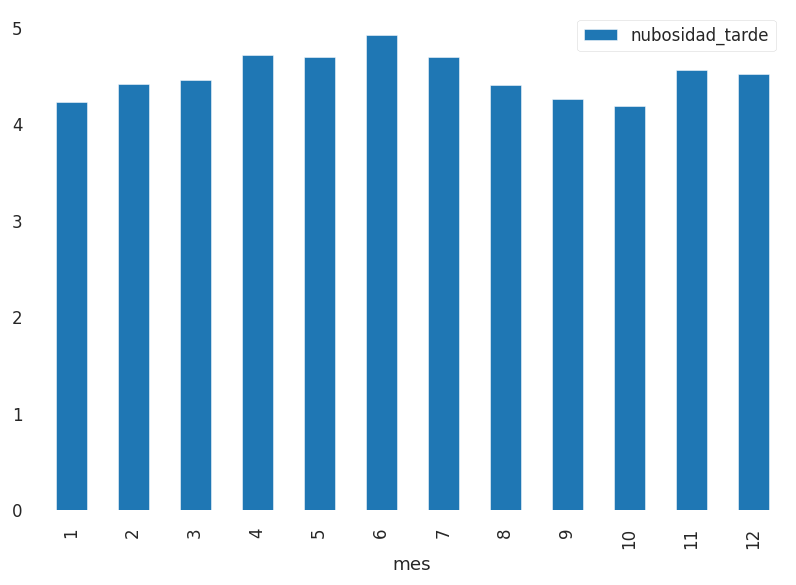

In [122]:
df[['dia','nubosidad_tarde']].groupby(df['dia'].dt.month).mean().plot(kind='bar', xlabel='mes')

<AxesSubplot:xlabel='mes'>

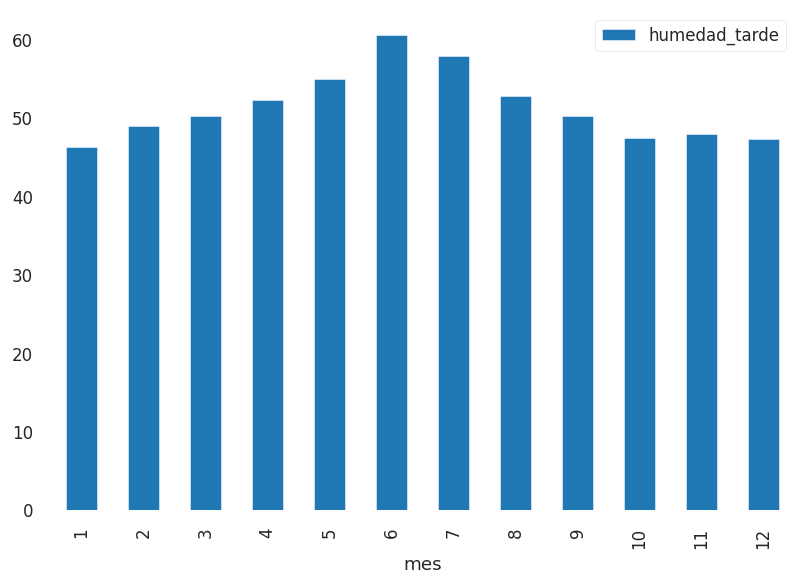

In [123]:
df[['dia','humedad_tarde']].groupby(df['dia'].dt.month).mean().plot(kind='bar', xlabel='mes')

<AxesSubplot:xlabel='mes'>

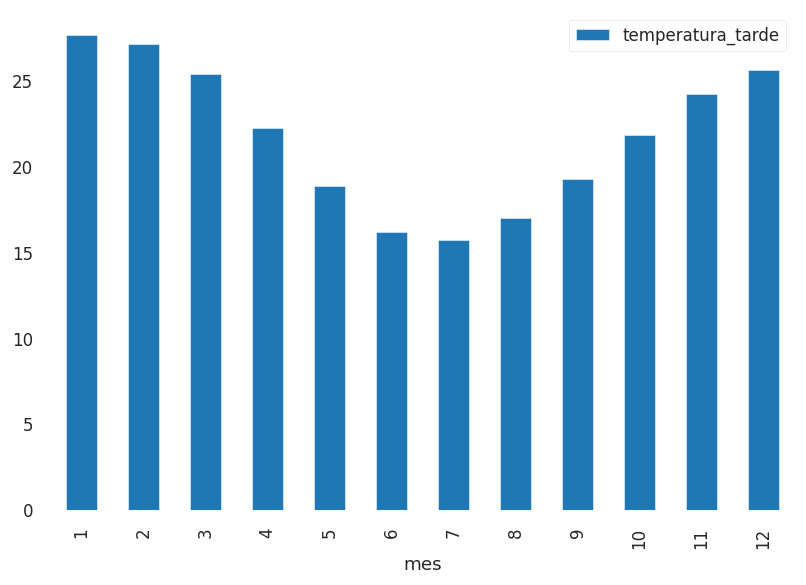

In [128]:
df[['dia','temperatura_tarde']].groupby(df['dia'].dt.month).mean().plot(kind='bar', xlabel='mes')

<AxesSubplot:xlabel='año'>

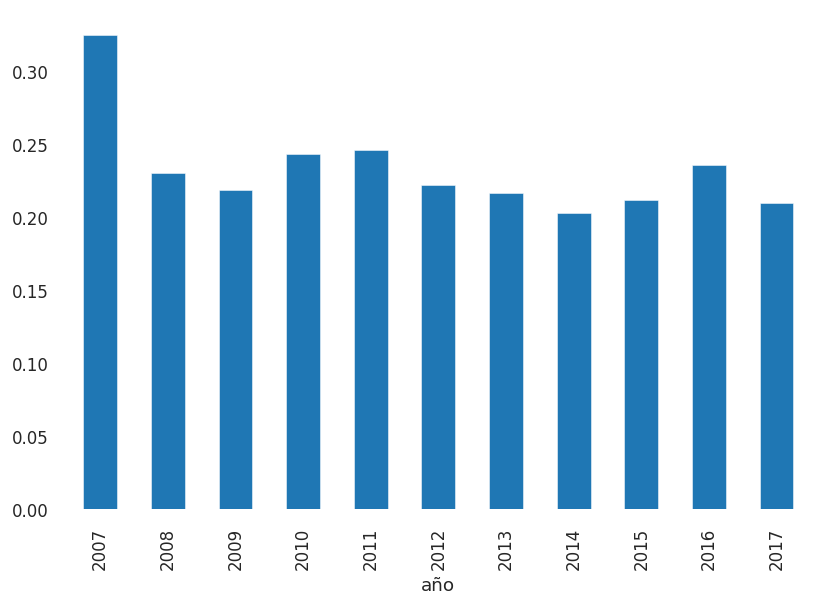

In [129]:
((df[df['llovieron_hamburguesas_al_dia_siguiente'] == 'si'].groupby(df['dia'].dt.year).size())/(df.groupby(df['dia'].dt.year).size())).plot(kind='bar', xlabel='año')


<AxesSubplot:xlabel='mes', ylabel='año'>

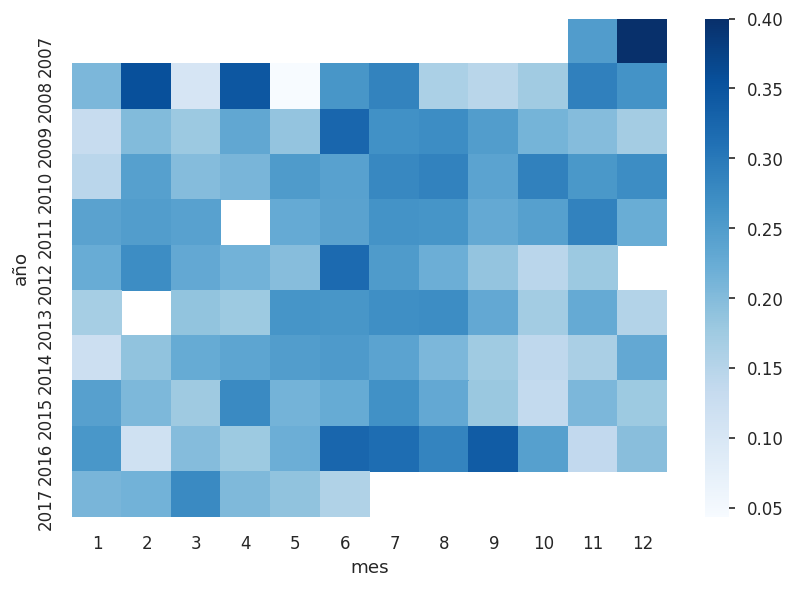

In [130]:
mes_anio = ((df[df['llovieron_hamburguesas_al_dia_siguiente'] == 'si'].groupby([df['dia'].dt.month, df['dia'].dt.year]).size())/(df.groupby([df['dia'].dt.month, df['dia'].dt.year]).size())).rename_axis(['mes','año']).to_frame()
mes_anio.columns = ['llovieron_hamburguesas_al_dia_siguiente']
mes_anio = mes_anio.reset_index(level=[0,1])
sns.heatmap(pd.pivot_table(mes_anio, index='año', columns='mes', values='llovieron_hamburguesas_al_dia_siguiente'), cmap='Blues')


## ¿Como varía el clima segun el barrio?

Graficamos la proporción de veces que llovieron hamburguesas en cada barrio respecto de la cantidad total de muestras tomadas por barrio. Comparamos ordenando de forma descendente.

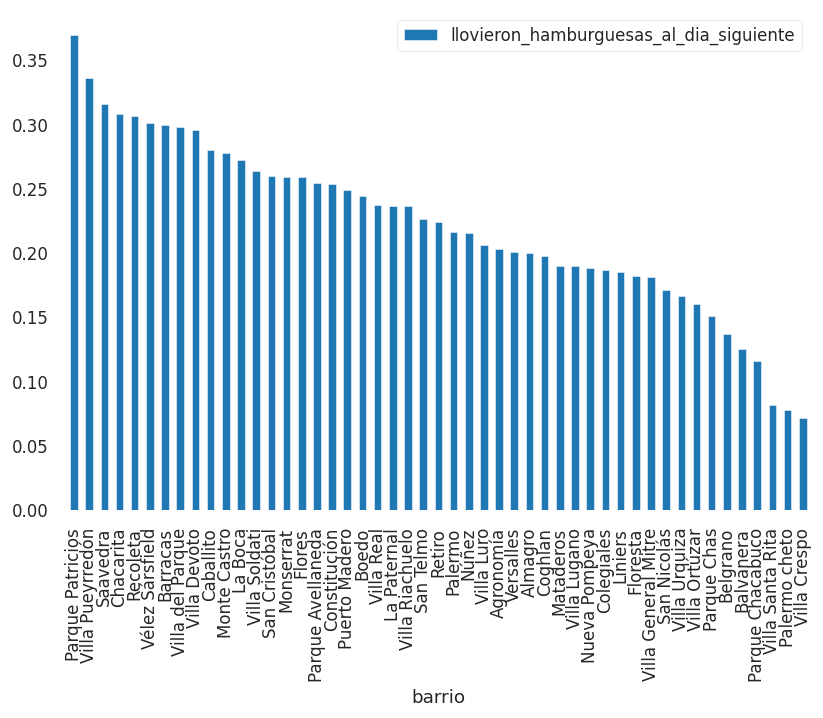

In [17]:
plt.rcParams["figure.dpi"] = 120
lluvia_por_barrios = df[['barrio', 'llovieron_hamburguesas_al_dia_siguiente']][df['llovieron_hamburguesas_al_dia_siguiente']=='si'].groupby('barrio').count()

lluvia_por_barrios /=  df[['barrio', 'llovieron_hamburguesas_al_dia_siguiente']].groupby('barrio').count()

lluvia_por_barrios.sort_values(by = 'llovieron_hamburguesas_al_dia_siguiente', ascending=False).plot(kind = 'bar')

plt.show()

Graficamos el promedio de horas de sol por barrio, y notamos que en varios no se tomaron datos de dicho atributo.

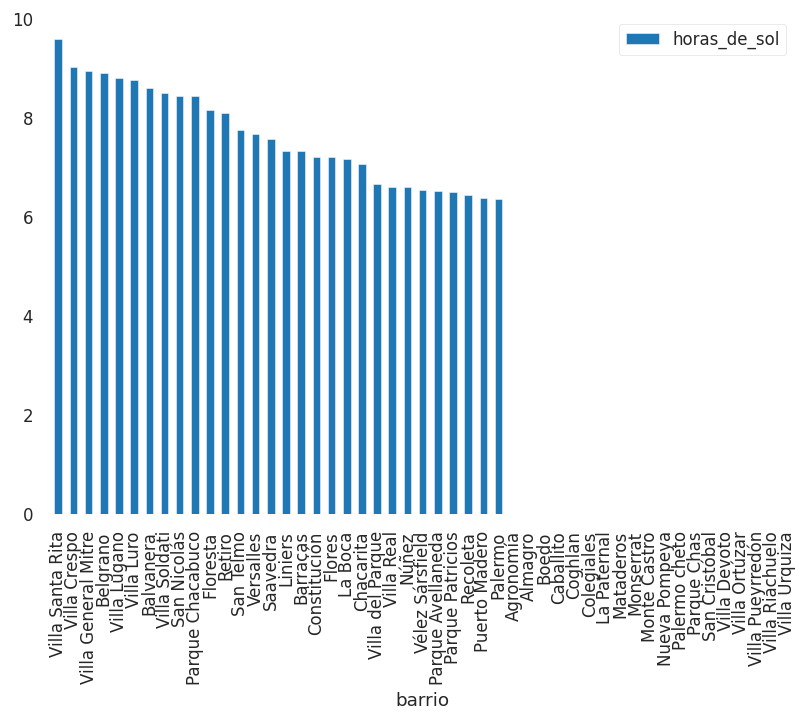

In [22]:
plt.rcParams["figure.dpi"] = 120

df[['barrio', 'horas_de_sol']].groupby('barrio').mean().sort_values(by = 'horas_de_sol', ascending=False).plot(kind = 'bar')

plt.show()

In [ ]:
Hacemos el mismo analisis que el anterior, pero con los atributos 'humedad_tarde' y 'humedad_temprana'.

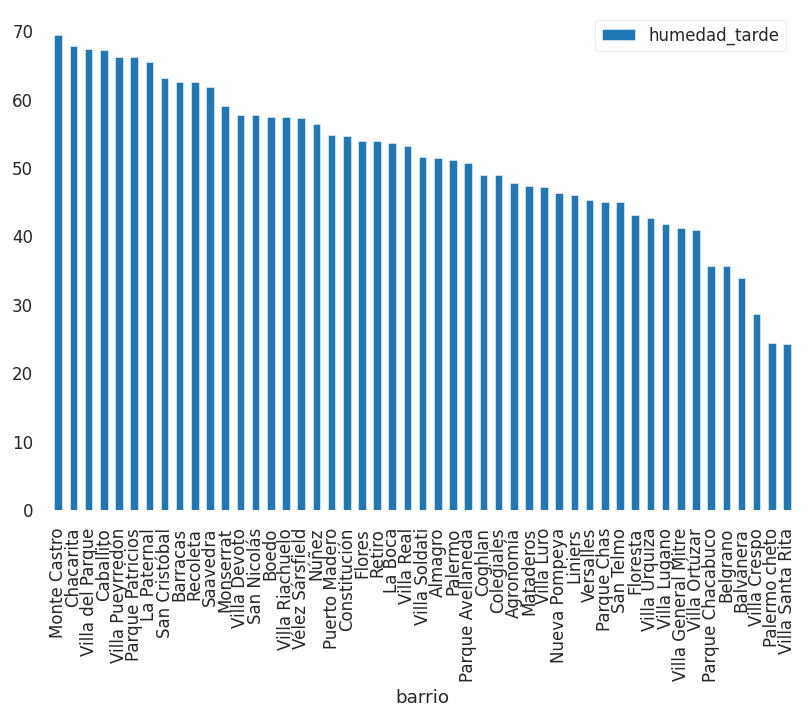

In [23]:
plt.rcParams["figure.dpi"] = 120

df[['barrio', 'humedad_tarde']].groupby('barrio').mean().sort_values(by = 'humedad_tarde', ascending=False).plot(kind = 'bar')

plt.show()

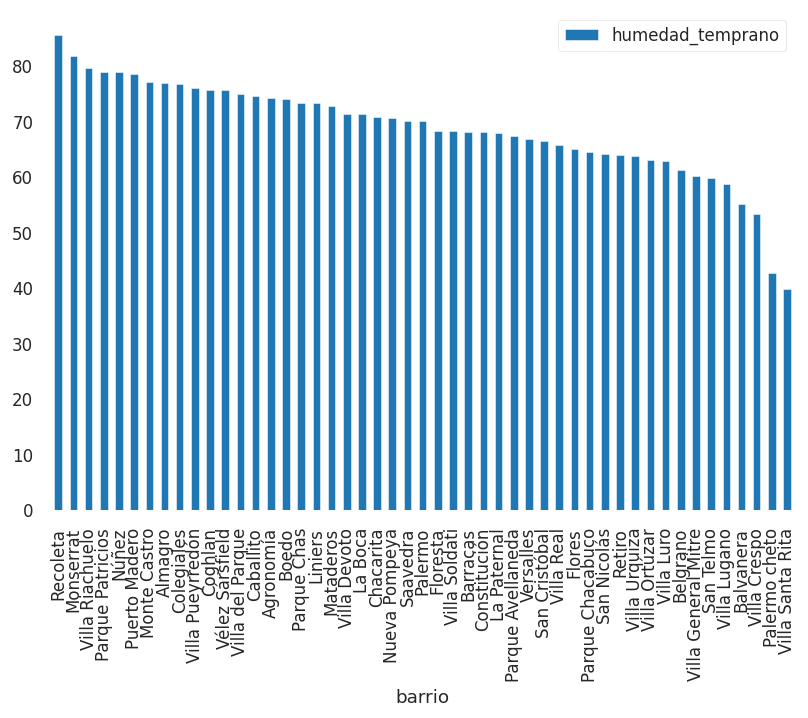

In [24]:
plt.rcParams["figure.dpi"] = 120

df[['barrio', 'humedad_temprano']].groupby('barrio').mean().sort_values(by = 'humedad_temprano', ascending=False).plot(kind = 'bar')

plt.show()

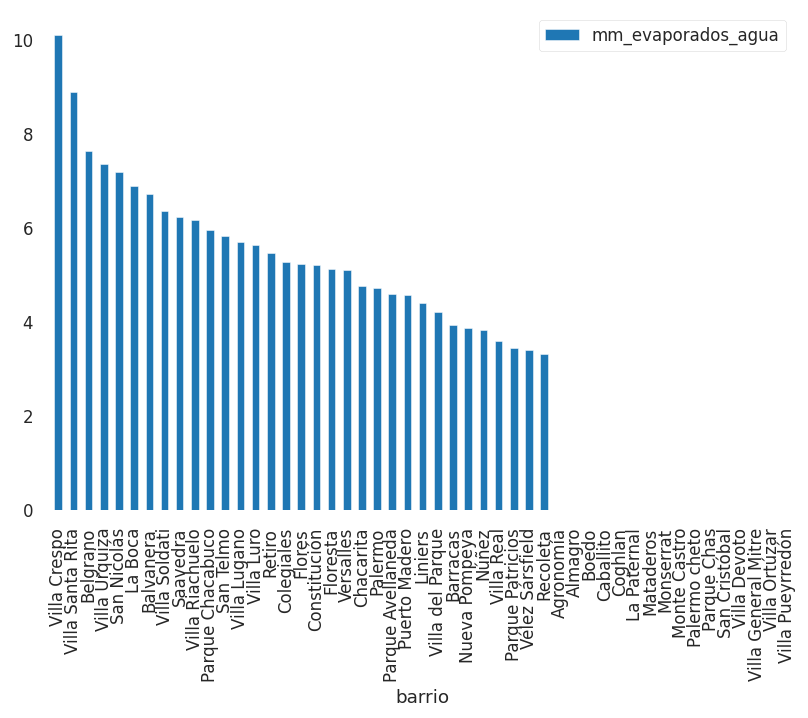

In [25]:
plt.rcParams["figure.dpi"] = 120

df[['barrio', 'mm_evaporados_agua']].groupby('barrio').mean().sort_values(by = 'mm_evaporados_agua', ascending=False).plot(kind = 'bar')

plt.show()

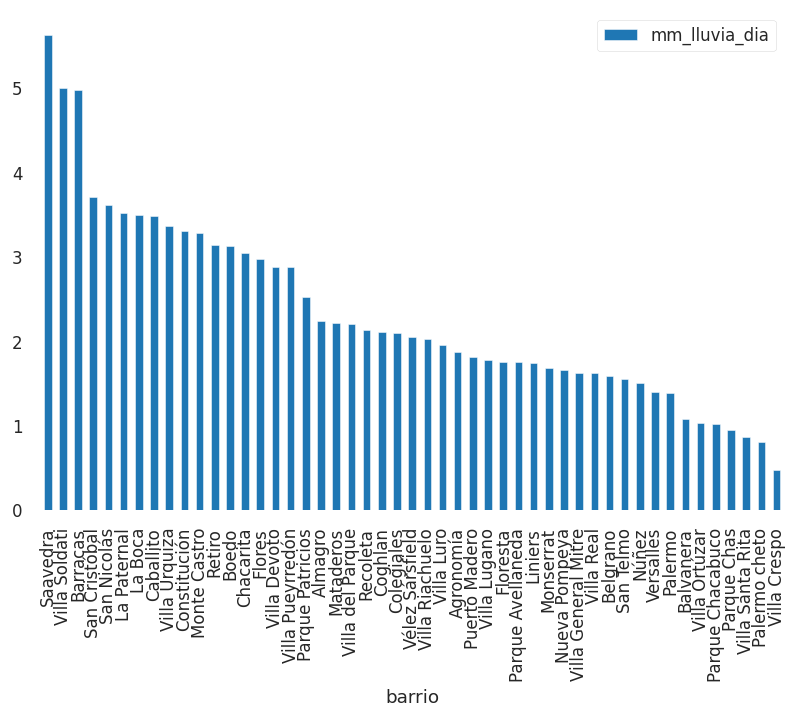

In [26]:
plt.rcParams["figure.dpi"] = 120

df[['barrio', 'mm_lluvia_dia']].groupby('barrio').mean().sort_values(by = 'mm_lluvia_dia', ascending=False).plot(kind = 'bar')

plt.show()

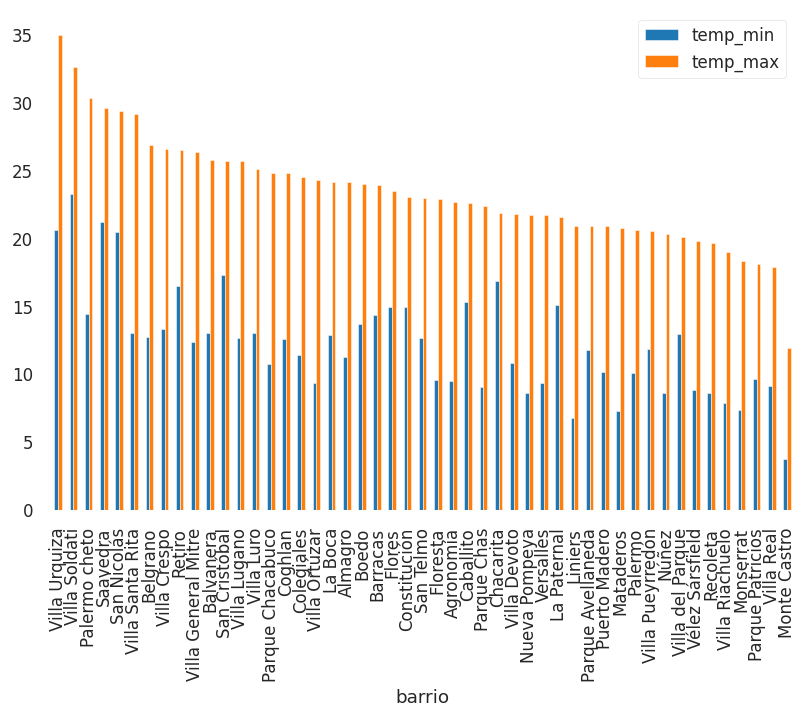

In [27]:
plt.rcParams["figure.dpi"] = 120

df[['barrio', 'temp_min', 'temp_max']].groupby('barrio').mean().sort_values(by = 'temp_max', ascending=False).plot(kind = 'bar')

plt.show()

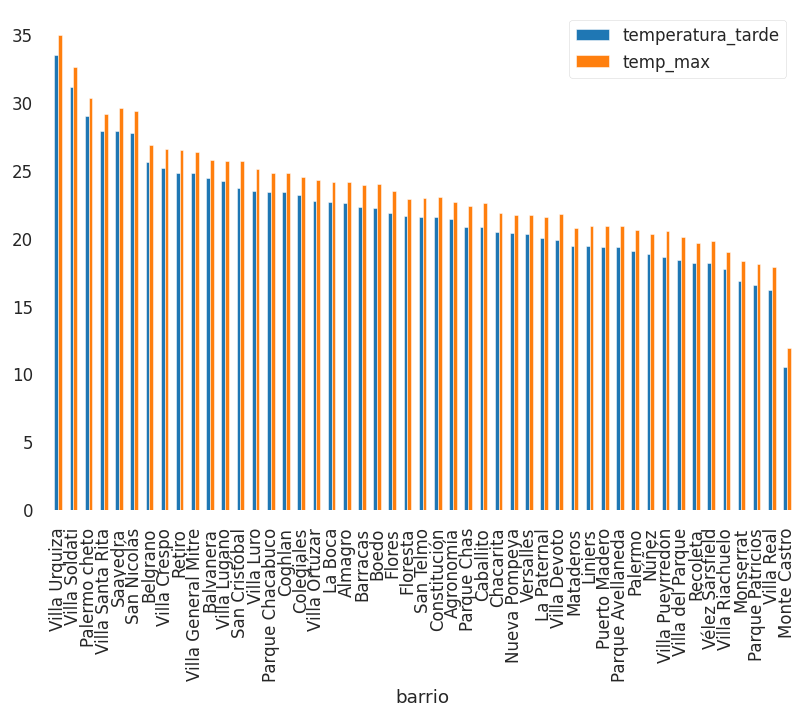

In [28]:
plt.rcParams["figure.dpi"] = 120

df[['barrio', 'temperatura_tarde', 'temp_max']].groupby('barrio').mean().sort_values(by = 'temperatura_tarde', ascending=False).plot(kind = 'bar')

plt.show()

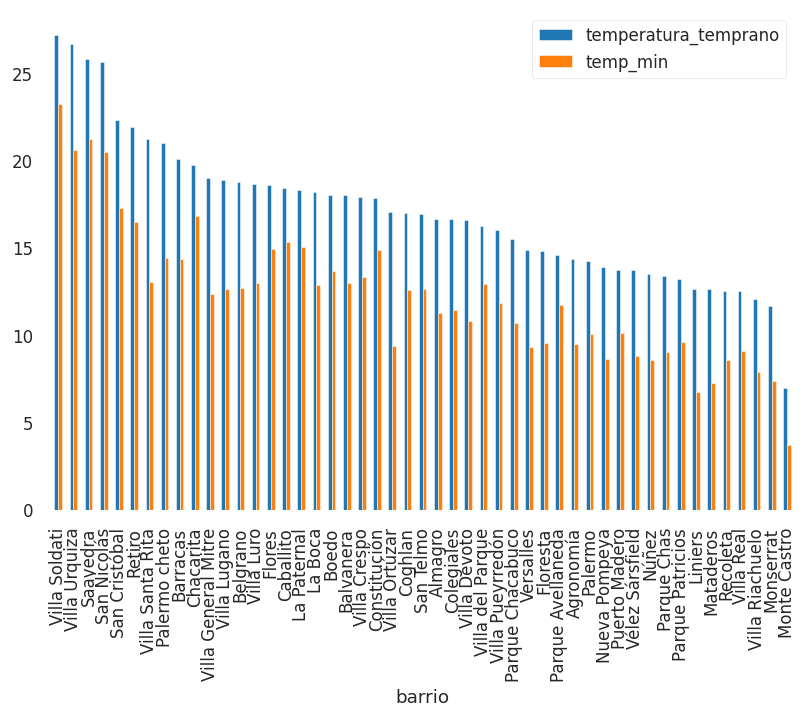

In [29]:
plt.rcParams["figure.dpi"] = 120

df[['barrio', 'temperatura_temprano', 'temp_min']].groupby('barrio').mean().sort_values(by = 'temperatura_temprano', ascending=False).plot(kind = 'bar')

plt.show()

<AxesSubplot:>

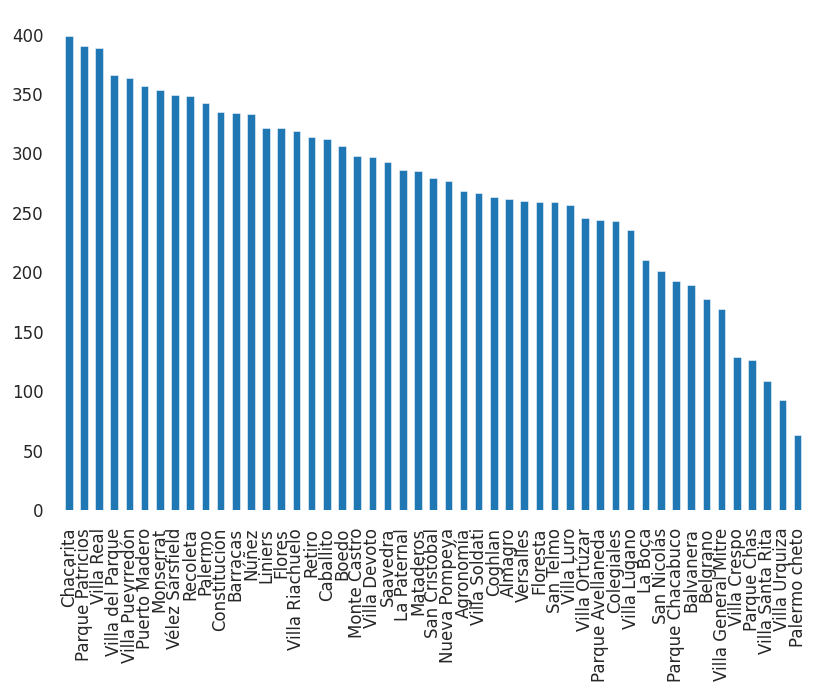

In [131]:
df_no_si['barrio'].value_counts().plot(kind='bar')

<AxesSubplot:xlabel='direccion_viento_tarde', ylabel='barrio'>

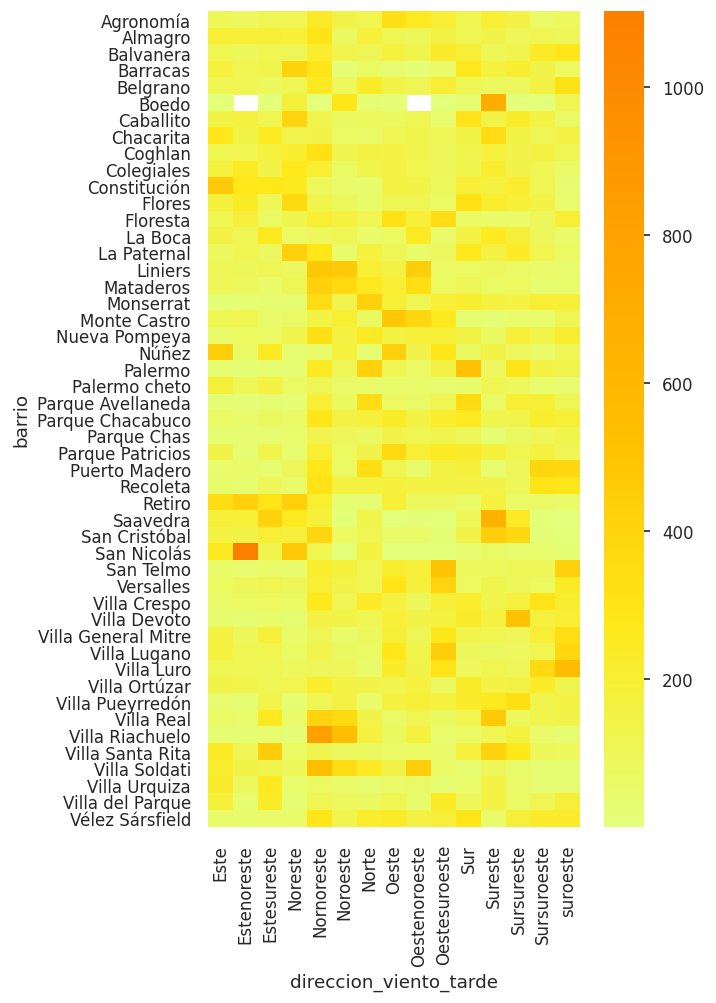

In [132]:
plt.figure(figsize=(5, 9))
sns.heatmap(pd.pivot_table(df, index='barrio', columns='direccion_viento_tarde', aggfunc='size'), xticklabels=True, yticklabels=True, cmap='Wistia')

In [133]:
pd.pivot_table(df, index='barrio', columns='llovieron_hamburguesas_al_dia_siguiente', aggfunc='size')

llovieron_hamburguesas_al_dia_siguiente,no,si
barrio,,
Agronomía,1895,482
Almagro,1865,465
Balvanera,2101,301
Barracas,1671,713
Belgrano,1956,310
Boedo,1780,575
Caballito,1676,652
Chacarita,1626,722
Coghlan,1912,471


In [134]:
pd.pivot_table(df, index='barrio', columns='llovieron_hamburguesas_hoy', aggfunc='size').sort_values(by='no', ascending=False)

llovieron_hamburguesas_hoy,no,si
barrio,,
Villa Crespo,2246,170
Liniers,2210,499
Villa Santa Rita,2201,196
Parque Chacabuco,2159,273
Balvanera,2087,307
Villa Luro,2054,524
San Nicolás,2038,433
Villa Ortúzar,1976,373
Nueva Pompeya,1973,442


## ¿Como se relaciona la temperatura con la variable target?


<AxesSubplot:xlabel='temp_max', ylabel='temperatura_tarde'>

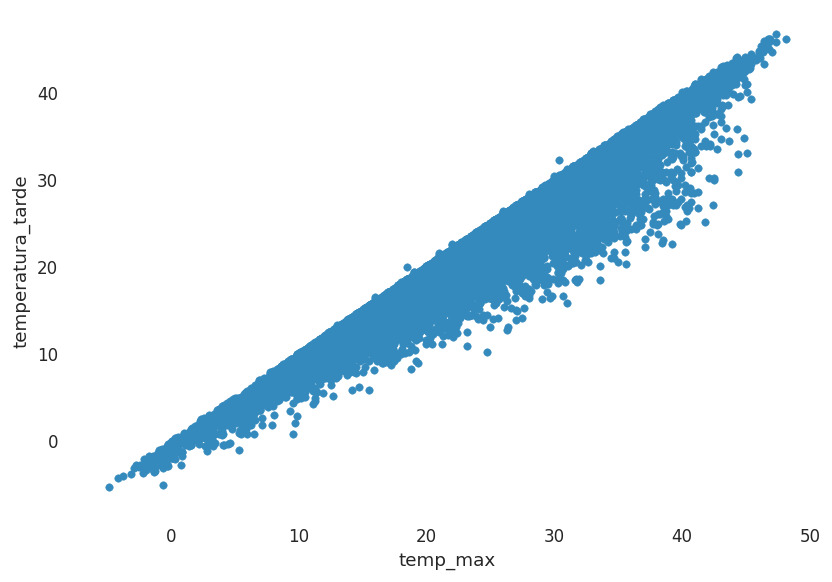

In [30]:
df.plot(
    x='temp_max',
    y='temperatura_tarde',
    kind='scatter',
)

<AxesSubplot:xlabel='temp_min', ylabel='temperatura_temprano'>

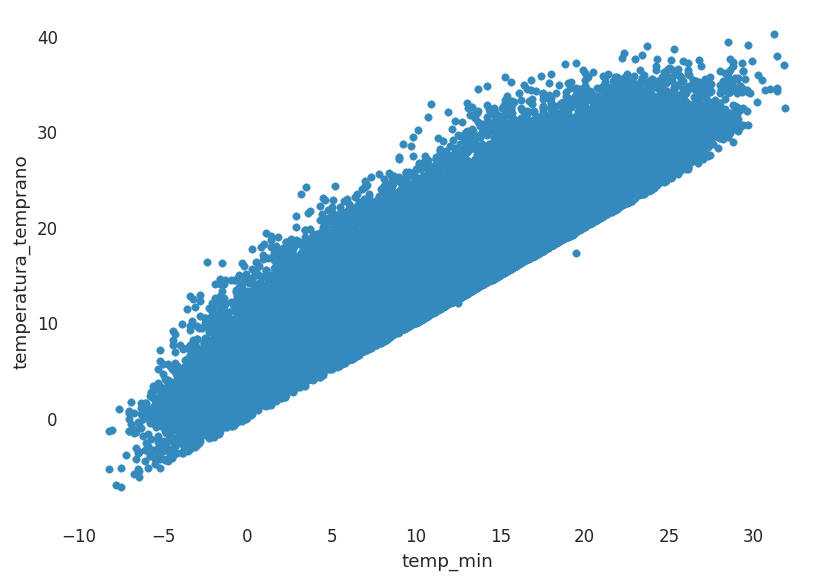

In [31]:
df.plot(
    x='temp_min',
    y='temperatura_temprano',
    kind='scatter',
)

<AxesSubplot:xlabel='temp_max', ylabel='temp_min'>

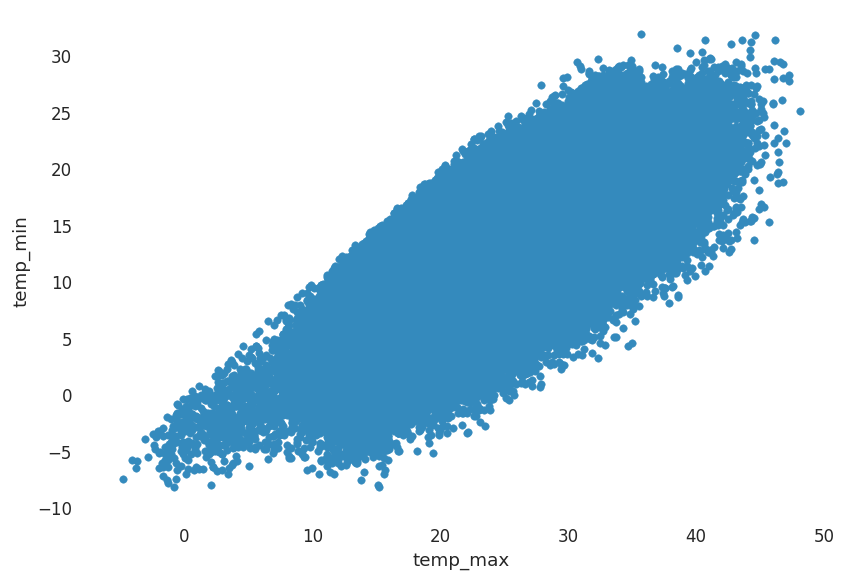

In [97]:
df.plot(x='temp_max', y='temp_min', kind='scatter')

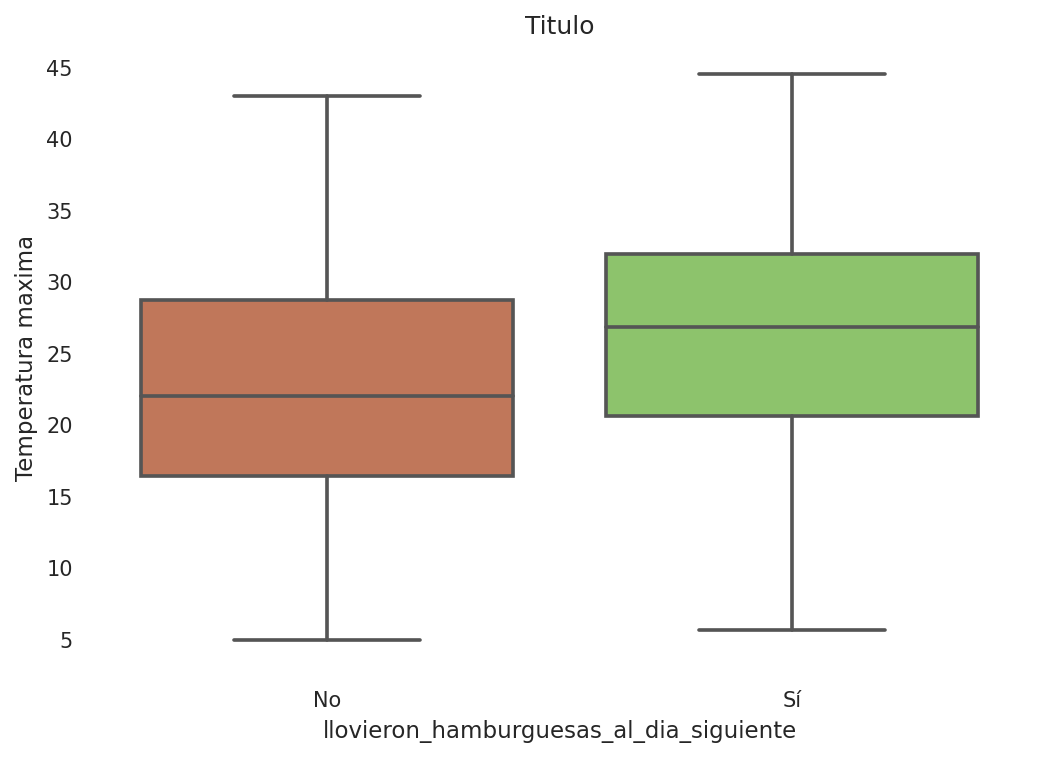

In [139]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df[(df['presion_atmosferica_tarde']<1013) & (df['nubosidad_tarde'] > 6)],
       
    y='temp_max',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Temperatura maxima")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

## ¿Como se relaciona la humedad con la variable target?

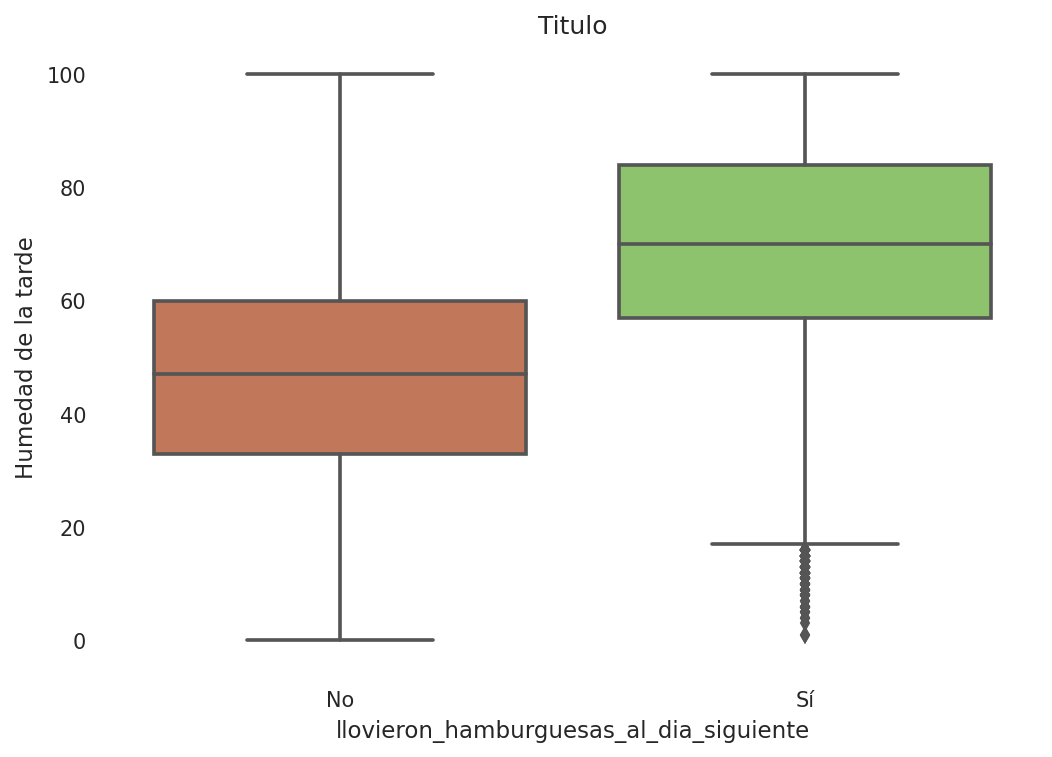

In [ ]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
    y='humedad_tarde',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Humedad de la tarde")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

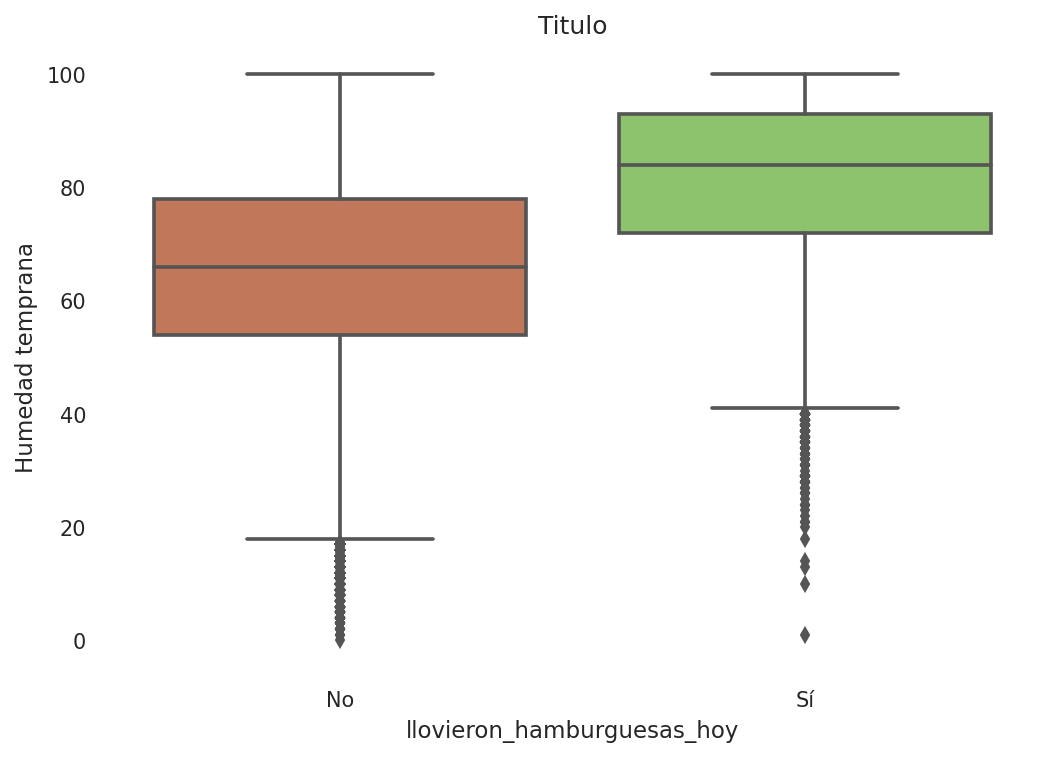

In [142]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
    y='humedad_temprano',
    x='llovieron_hamburguesas_hoy',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Humedad temprana")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

<AxesSubplot:ylabel='Density'>

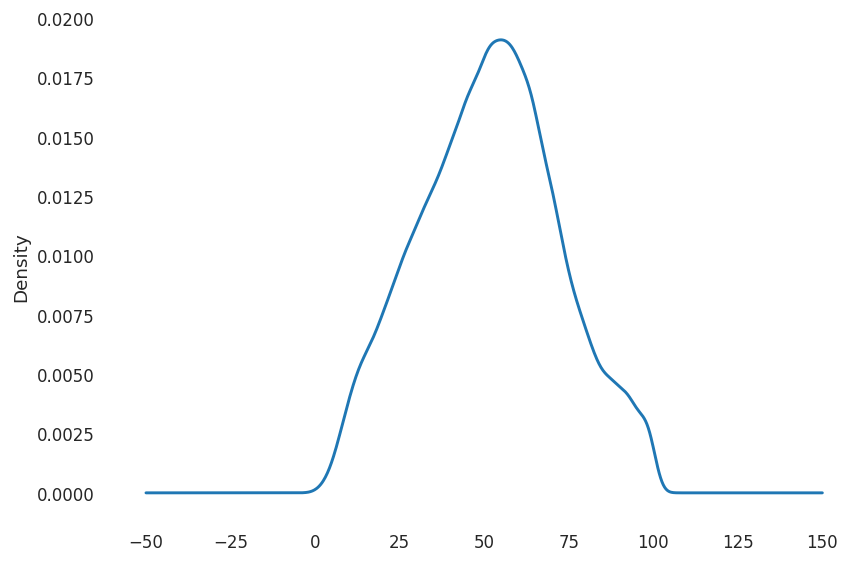

In [143]:
df['humedad_tarde'].plot(kind='density')

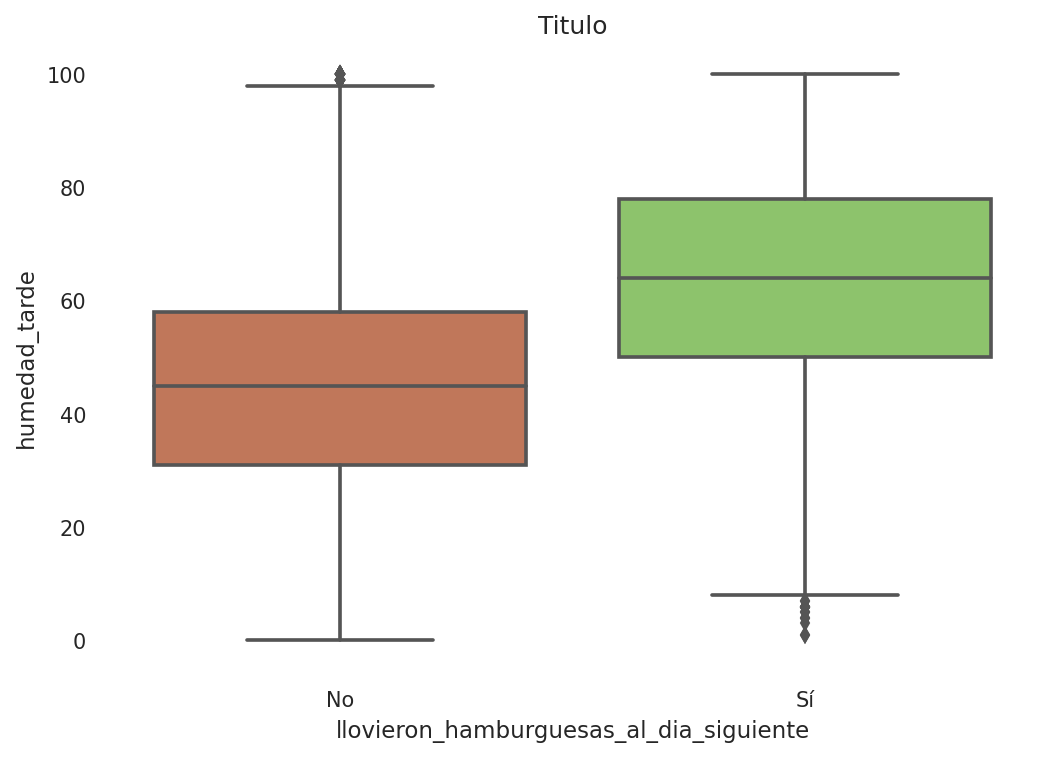

In [144]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df_no,
    y='humedad_tarde',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xticks([False, True], ["No", "Sí"])
plt.show()

## ¿Como se relaciona la nubosidad con la variable target?


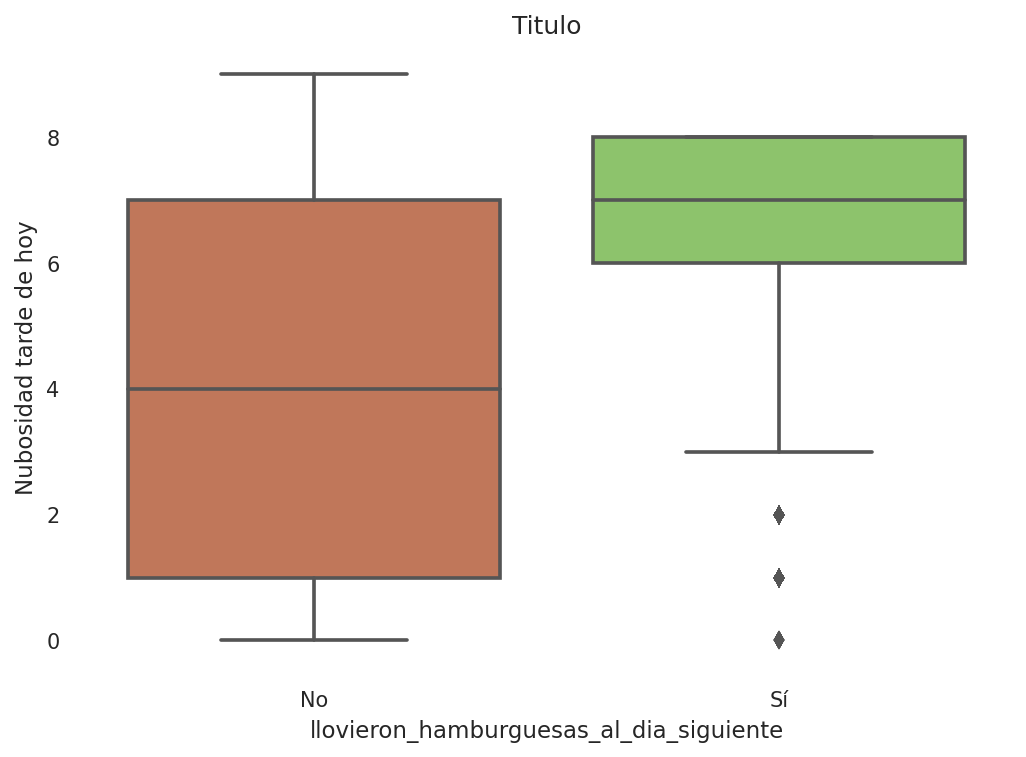

In [146]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
       
    y='nubosidad_tarde',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Nubosidad tarde de hoy")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

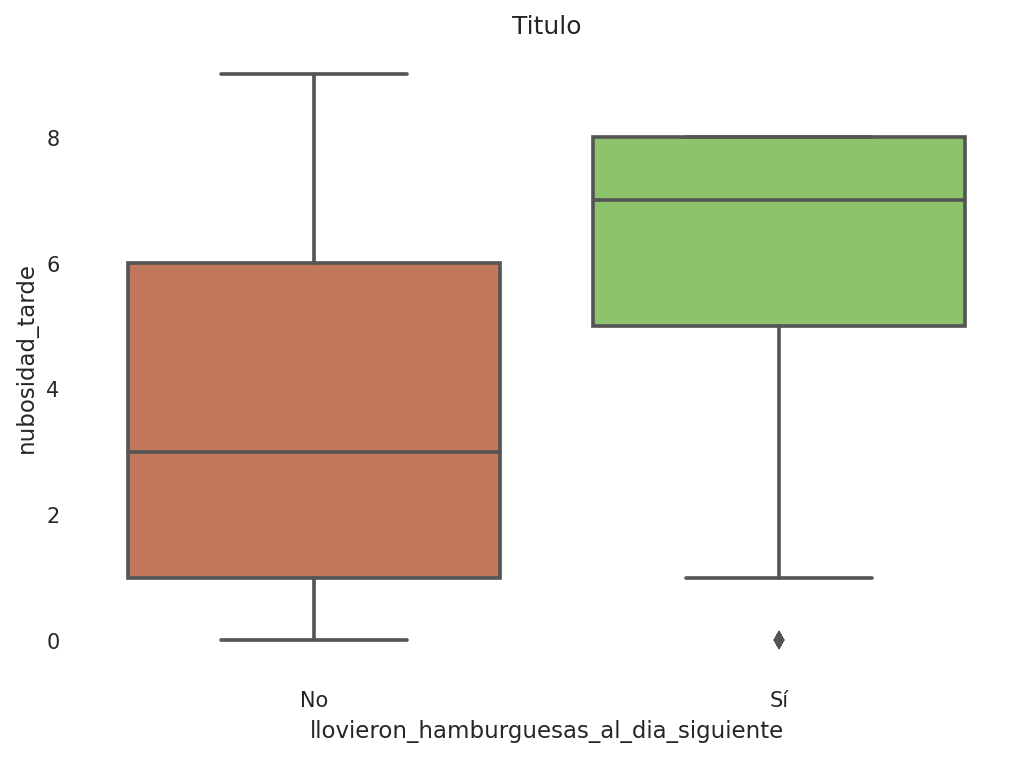

In [147]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df_no,
    y='nubosidad_tarde',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xticks([False, True], ["No", "Sí"])
plt.show()

## ¿Como se relaciona el viento con la variable target?


<AxesSubplot:>

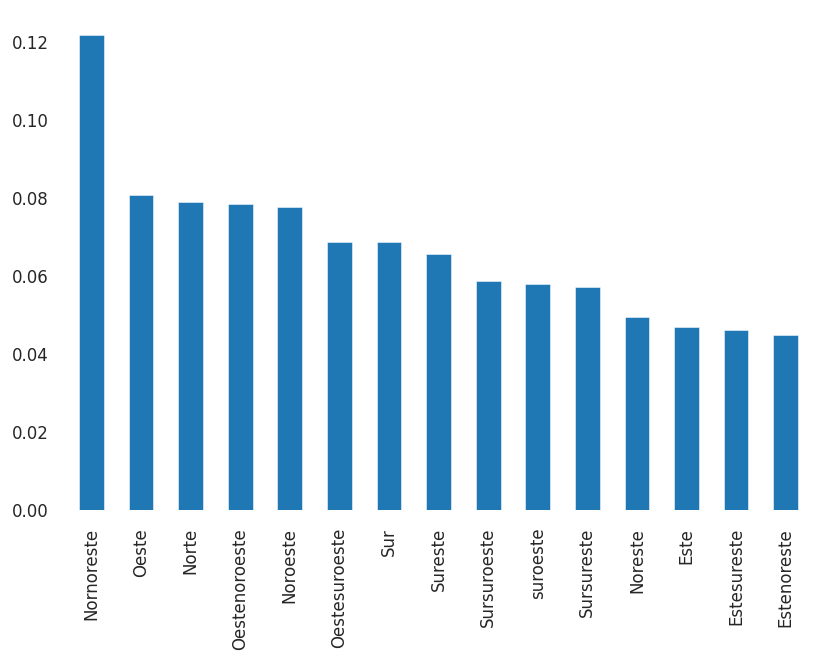

In [38]:
(df[df['llovieron_hamburguesas_al_dia_siguiente'] == 'si']['direccion_viento_tarde']).value_counts(normalize = True).sort_values(ascending=False).plot(kind='bar')



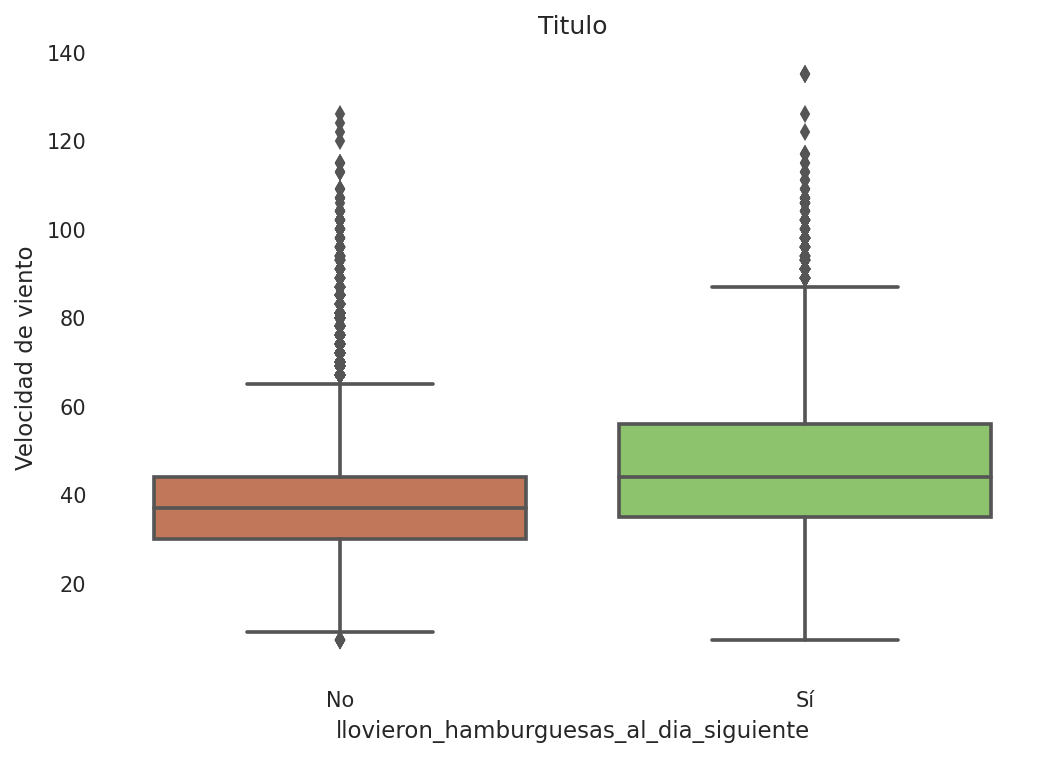

In [148]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
       
    y='rafaga_viento_max_velocidad',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Velocidad de viento")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

<AxesSubplot:>

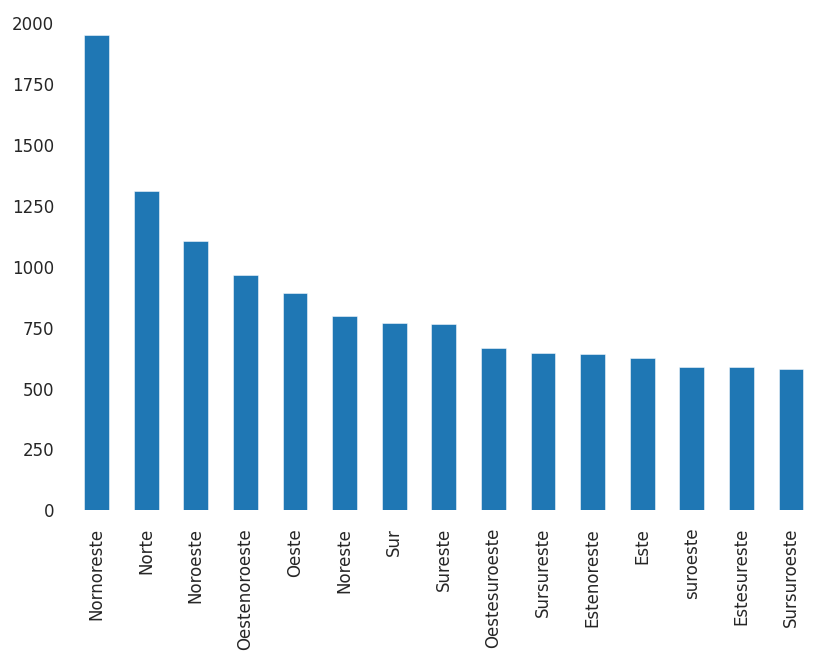

In [149]:
df_no = df[df['llovieron_hamburguesas_hoy'] == 'no']
df_no_si = df[(df['llovieron_hamburguesas_hoy'] == 'no') & (df['llovieron_hamburguesas_al_dia_siguiente'] == 'si')]
df_no_si['direccion_viento_tarde'].value_counts().plot(kind='bar')

<AxesSubplot:>

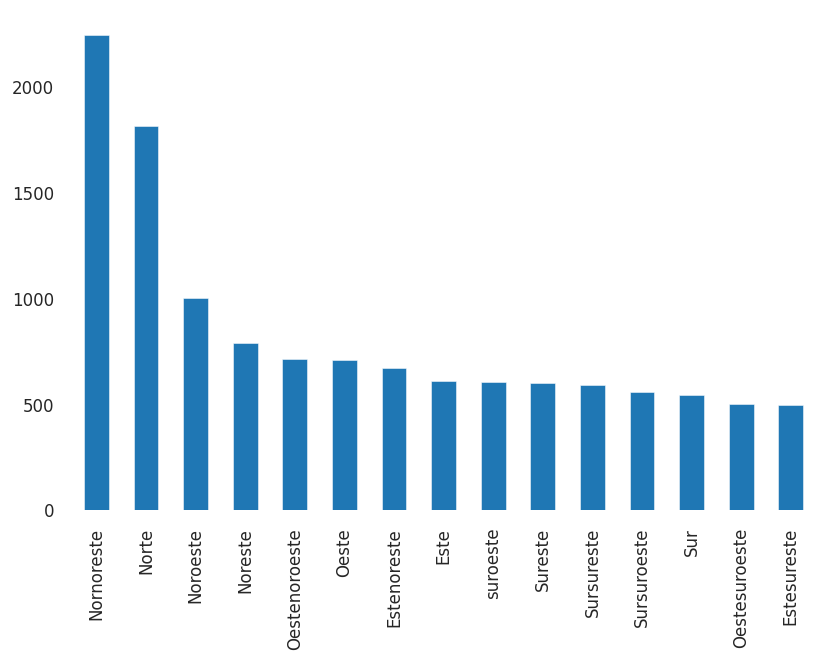

In [150]:
df_no_si['direccion_viento_temprano'].value_counts().plot(kind='bar')

## ¿Como se relaciona la presión atmosférica con la variable target?

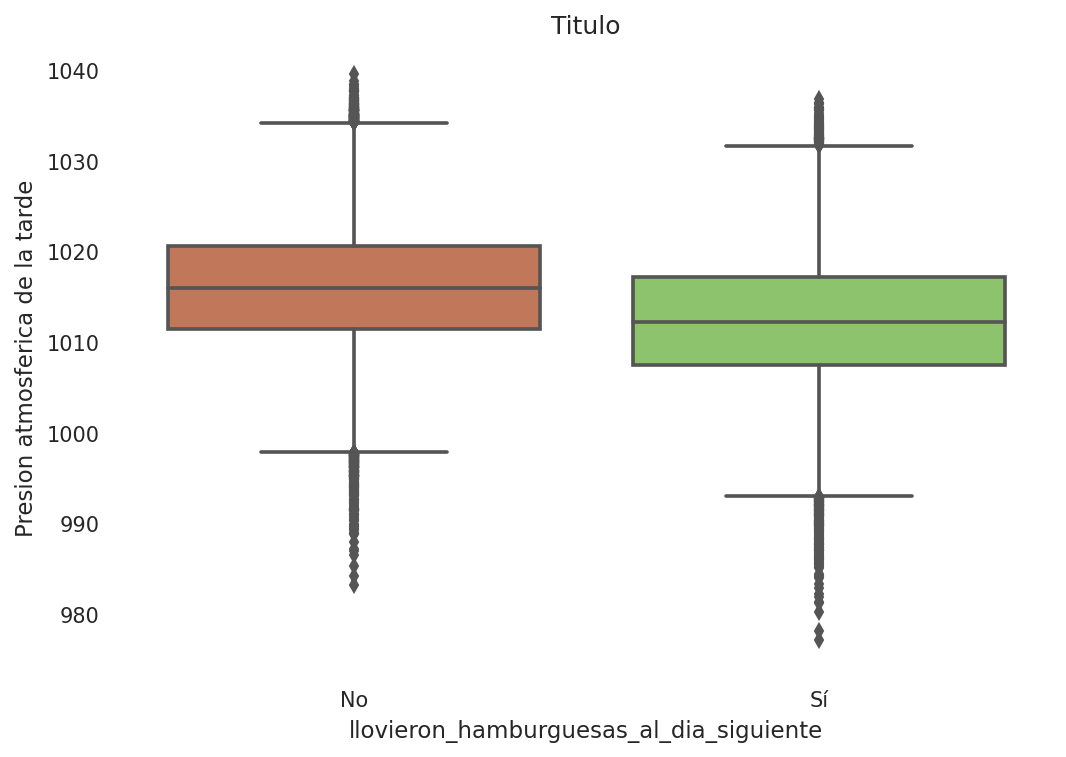

In [152]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
       
    y='presion_atmosferica_tarde',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Presion atmosferica de la tarde")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

## ¿Como se relaciona los milimetros evaporados de agua con la variable target?

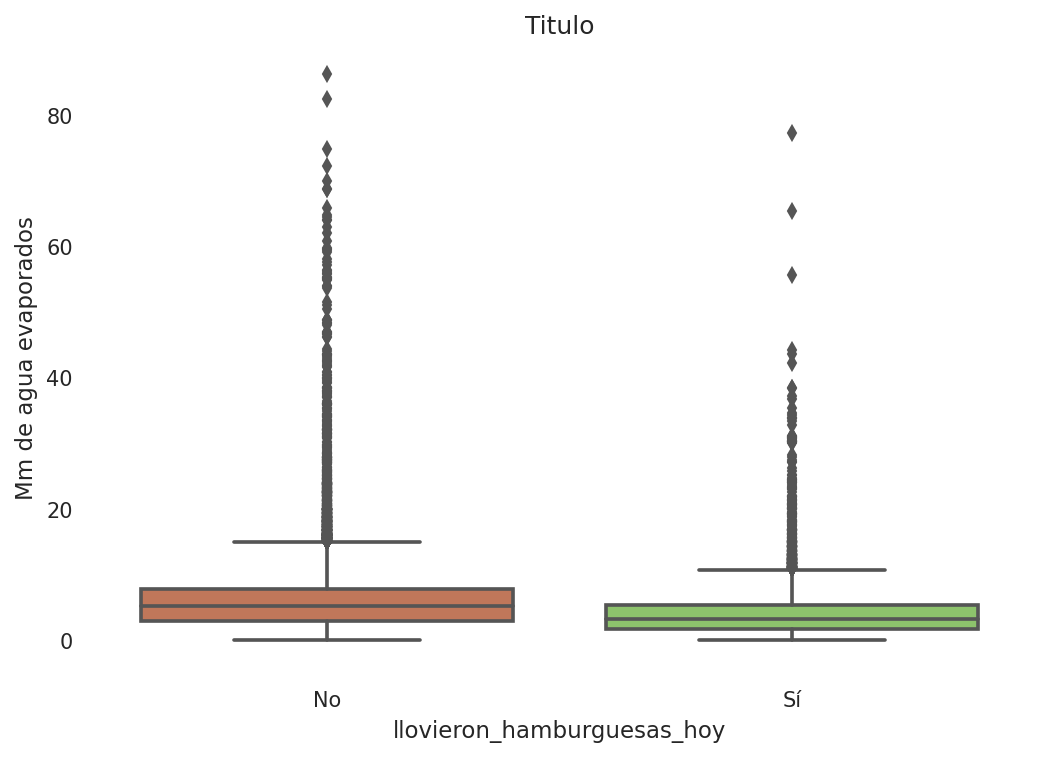

In [151]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
       
    y='mm_evaporados_agua',
    x='llovieron_hamburguesas_hoy',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Mm de agua evaporados")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

## ¿Como se relaciona las horas de sol con la variable target?

<AxesSubplot:>

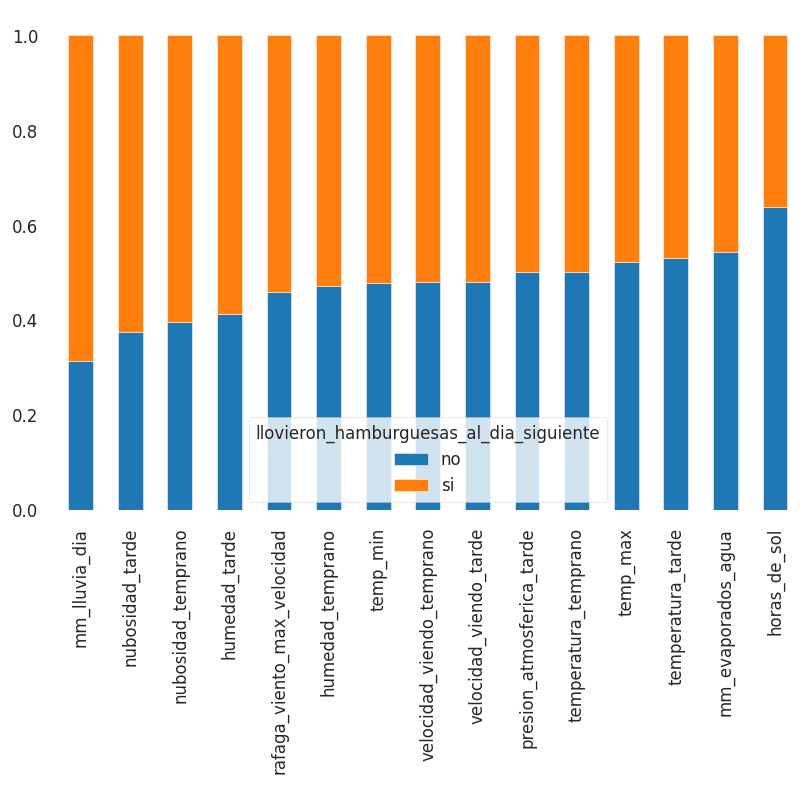

In [55]:
df_no_target_mean = df_no.groupby('llovieron_hamburguesas_al_dia_siguiente').mean().transpose().drop(['id', 'presion_atmosferica_temprano'])
df_no_target_mean_normalized = df_no_target_mean.div(df_no_target_mean.sum(axis=1), axis=0)
df_no_target_mean_normalized = df_no_target_mean_normalized.sort_values(by = 'si', ascending=False)
df_no_target_mean_normalized.plot(kind='bar', stacked=True)

<AxesSubplot:>

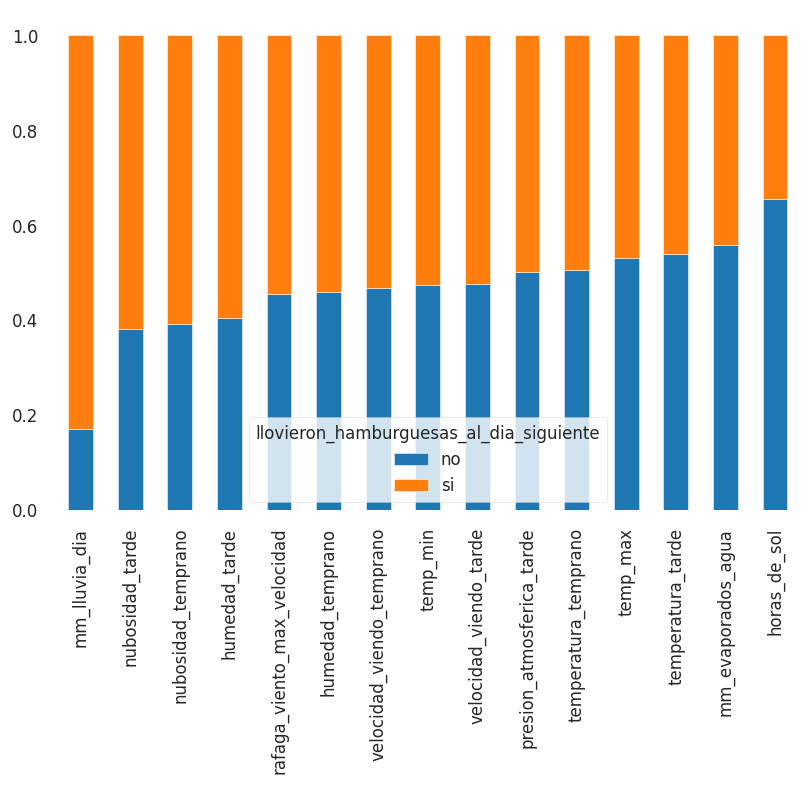

In [138]:
df_target_mean = df.groupby('llovieron_hamburguesas_al_dia_siguiente').mean().transpose().drop(['id', 'presion_atmosferica_temprano'])
df_target_mean_normalized = df_target_mean.div(df_target_mean.sum(axis=1), axis=0)
df_target_mean_normalized = df_target_mean_normalized.sort_values(by = 'si', ascending=False)
df_target_mean_normalized.plot(kind='bar', stacked=True)